# Seating optimization

This notebook is an implementation of a simple stochastic algorithm to find a (quasi-) optimal solution for assigning guests to tables at events like weddings. It assumes that every pair of guests as a certain "favorability" score based on how well (or poorly) they can be expected to get along. It assigns each guest to a table with the goal of maximizing the total favorability of guests sitting at the same table. This problem is #very# computationally hard to solve exactly for any non-trivial number of guests, but even a very naive, simple optimization algorithm does a pretty good job, pretty quickly. Note: this is not quite done, but close.

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from itertools import combinations
import matplotlib.pyplot as plt

### Importing guests

First, we need to import the list of guest names at the wedding. I've used as a default a list of 13 guests. If you want to use your own list, edit `sample_names.csv` putting one name in each row, or use a csv in similar format, replacing the reference to the file name below.

In [2]:
names = pd.read_csv("sample_names.csv")
display(names)

,Name
0,Alice
1,Bob
2,Charlie
3,David
4,Eliza
5,Frank
6,Greg
7,Heather
8,Igor
9,Jack


What we care about, though, is the interactions _between_ each pair of guests. We can visualize that by rearranging the guest list into an upper triangular matrix.

In [3]:
pairs = pd.DataFrame(0.0,index=names.values[:,0],columns=names.values[:,0])
pairs = pairs.where(np.triu(np.ones(pairs.shape),1).astype(np.bool))
display(pairs)

,Alice,Bob,Charlie,David,Eliza,Frank,Greg,Heather,Igor,Jack,...,Nancy,Oscar,Peter,Quentin,Rose,Steve,Tom,Ulysses,Veronica,Walter
Alice,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bob,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Charlie,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
David,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eliza,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Frank,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Greg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Heather,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Igor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jack,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In order to actually enter in and process this data, though, it can be helpful to "unstack" these pairs into list form. Below, I turn the pairs into a list and save it to `pairs.csv`, which can be edited in order to enter in the suitability of each pair of guests.

In [4]:
pairs = pairs.stack().reset_index()
pairs.columns = ['Person1','Person2','Suitability']
display(pairs)
pairs.to_csv('pairs.csv')

,Person1,Person2,Suitability
0,Alice,Bob,0.0
1,Alice,Charlie,0.0
2,Alice,David,0.0
3,Alice,Eliza,0.0
4,Alice,Frank,0.0
5,Alice,Greg,0.0
6,Alice,Heather,0.0
7,Alice,Igor,0.0
8,Alice,Jack,0.0
9,Alice,Kelly,0.0


After you've entered in as many pairwise suitability scores as you want, you can read the data back in. I've also given the option of randomly generating some suitability scores, with some couples that should be seated together, some people who (due to sordid history) should not sit together, and the rest of pairs mildly positive or negative.

In [17]:
newpairs = pd.read_csv('pairs.csv',index_col=0)

# COMMENT OUT THESE NEXT THREE LINES IF YOU'VE ENTERED IN YOUR OWN SCORES
newpairs['Suitability'] = np.random.uniform(-0.25,0.25,size=newpairs['Suitability'].size)
newpairs.loc[newpairs.sample(n=(names.size/4)).index,'Suitability'] = 1
newpairs.loc[newpairs.sample(n=(names.size/10)).index,'Suitability'] = -1
#

costMatrix = newpairs.set_index(['Person1', 'Person2']).unstack()
display(costMatrix)
costMatrix = costMatrix.values

Suitability                                                    \
Person2          Bob   Charlie     David     Eliza     Frank      Greg   
Person1                                                                  
Alice      -0.185296 -0.041136  0.063393  0.048039 -0.057525  0.140283   
Bob              NaN  0.062657 -0.212972  0.159043  0.037004  1.000000   
Charlie          NaN       NaN -0.056415  0.117301 -0.026250 -1.000000   
David            NaN       NaN       NaN -0.102418  0.137439 -0.112221   
Eliza            NaN       NaN       NaN       NaN -0.106502 -0.166495   
Frank            NaN       NaN       NaN       NaN       NaN  0.140567   
Greg             NaN       NaN       NaN       NaN       NaN       NaN   
Heather          NaN       NaN       NaN       NaN       NaN       NaN   
Igor             NaN       NaN       NaN       NaN       NaN       NaN   
Jack             NaN       NaN       NaN       NaN       NaN       NaN   
Kelly            NaN       NaN       NaN       NaN       NaN       NaN   
Larry            NaN       NaN       NaN       NaN       NaN       NaN   
Mary             NaN       NaN       NaN       NaN       NaN       NaN   
Nancy            NaN       NaN       NaN       NaN       NaN       NaN   
Oscar            NaN       NaN       NaN       NaN       NaN       NaN   
Peter            NaN       NaN       NaN       NaN       NaN       NaN   
Quentin          NaN       NaN       NaN       NaN       NaN       NaN   
Rose             NaN       NaN       NaN       NaN       NaN       NaN   
Steve            NaN       NaN       NaN       NaN       NaN       NaN   
Tom              NaN       NaN       NaN       NaN       NaN       NaN   
Ulysses          NaN       NaN       NaN       NaN       NaN       NaN   
Veronica         NaN       NaN       NaN       NaN       NaN       NaN   

                                                    ...               \
Person2    Heather      Igor      Jack     Kelly    ...        Nancy   
Person1                                             ...                
Alice     0.248951  0.095929  0.249137  0.148975    ...     0.105408   
Bob       0.169433 -0.032796 -0.172525  0.072950    ...     0.120407   
Charlie  -0.010337  0.208004 -0.083660 -0.025430    ...    -0.056763   
David     0.137397 -0.116882 -0.130962  0.247611    ...     0.008884   
Eliza     0.179174 -0.215662 -0.130179 -0.232049    ...    -0.228723   
Frank    -0.024987  0.149678  0.094030 -0.071321    ...    -0.026806   
Greg      0.158304 -0.088823 -0.152075 -0.025155    ...    -0.180438   
Heather        NaN -0.025077  0.189100 -0.025410    ...     0.043228   
Igor           NaN       NaN  0.184838  0.194403    ...     0.018808   
Jack           NaN       NaN       NaN -0.071034    ...     0.168854   
Kelly          NaN       NaN       NaN       NaN    ...     0.059688   
Larry          NaN       NaN       NaN       NaN    ...     0.005897   
Mary           NaN       NaN       NaN       NaN    ...     0.148879   
Nancy          NaN       NaN       NaN       NaN    ...          NaN   
Oscar          NaN       NaN       NaN       NaN    ...          NaN   
Peter          NaN       NaN       NaN       NaN    ...          NaN   
Quentin        NaN       NaN       NaN       NaN    ...          NaN   
Rose           NaN       NaN       NaN       NaN    ...          NaN   
Steve          NaN       NaN       NaN       NaN    ...          NaN   
Tom            NaN       NaN       NaN       NaN    ...          NaN   
Ulysses        NaN       NaN       NaN       NaN    ...          NaN   
Veronica       NaN       NaN       NaN       NaN    ...          NaN   

                                                                      \
Person2      Oscar     Peter   Quentin      Rose     Steve       Tom   
Person1                                                                
Alice    -0.121377  0.121439 -0.045937 -0.012626 -0.148056 -0.188408   
Bob      -0.042835  0.094327 -0.209308  0.043415 -0.030731 -0.093665 

In order to set up the problem, we need to define the number of tables and the maximum number of guests for each (for simplicity, I'm assuming all tables are the same size). Here, we assume 5 tables of 5 people for 23 guests, meaning that two table spots are left empty. These are filled with empty chairs.

In [18]:
nTables = 5
tableSize = 5


nEmptyChairs = nTables*tableSize - names.size
allNames = names.copy()
for i in range(names.size,nTables*tableSize):
    allNames.loc[i] = "Empty Chair" 
fullCostMatrix = np.pad(costMatrix,((0,nEmptyChairs+1),(1,nEmptyChairs)), mode='constant', constant_values=0)
allNames['Table']=np.random.permutation(np.arange(allNames.size)/tableSize)
display(allNames)

,Name,Table
0,Alice,0
1,Bob,1
2,Charlie,2
3,David,0
4,Eliza,3
5,Frank,3
6,Greg,4
7,Heather,3
8,Igor,1
9,Jack,4


In [19]:
setup_details = dict(costs = fullCostMatrix, nTables = nTables, tableSize = tableSize)
class arrangement:
    def __init__(self,guests,setup_details):
        self.guests = guests
        self.costs = setup_details["costs"]
        self.nTables = setup_details["nTables"]
        self.tableSize = setup_details["tableSize"]
        self.favorability = np.nan
        self.previous_favorability = np.nan
        self.randomize_tables()
    def randomize_tables(self):
        self.tables = np.random.permutation(np.arange(self.guests.size)/self.tableSize)
        self.calculate_favorability()
    def calculate_favorability(self):
        xv, yv = np.meshgrid(self.tables, self.tables)
        self.favorability = np.nansum(self.costs[(xv == yv)*(np.triu(np.ones(self.costs.shape,dtype=bool),1))])
    def randomly_swap(self):
        #self.previous_favorability = self.favorability
        keepGoing = True
        while keepGoing:
            inds = np.random.choice(self.guests.size, 2, replace=False)
            if self.tables[inds[0]] != self.tables[inds[1]]:
                keepGoing = False
        temp = self.tables[inds[0]].copy()
        self.tables[inds[0]] = self.tables[inds[1]].copy()
        self.tables[inds[1]] = temp
        self.calculate_favorability()
    def adopt_new_arrangement(self,arrangement):
        self.tables = arrangement.tables.copy()
        self.favorability = arrangement.favorability.copy()

In [20]:
def simple_acceptance_function(cost1,cost2,temperature):
    if cost2 > cost1:
        return True
    else:
        return False
    
def annealing_acceptance_function(cost1,cost2,temperature):
    a = np.exp((cost2 - cost1)/temperature)
    if a >= 1:
        return True
    else:
        return np.random.random_sample() < a

def iterate(arr1,arr2,temperature):
    #arr2.randomly_swap()
    arr1.previous_favorability = arr1.favorability
    swap = annealing_acceptance_function(arr1.favorability,arr2.favorability,temperature)
    if swap:
        arr1.adopt_new_arrangement(arr2)
    else:
        arr2.adopt_new_arrangement(arr1)
    arr2.randomly_swap()

In [21]:
arr1 = arrangement(allNames["Name"].values,setup_details)
arr2 = arrangement(allNames["Name"].values,setup_details)
arr_best = arrangement(allNames["Name"].values,setup_details)
arr2.adopt_new_arrangement(arr1)
arr_best.adopt_new_arrangement(arr1)
arr2.randomly_swap()

/Users/zneedell/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
/Users/zneedell/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


<IPython.core.display.Javascript object>


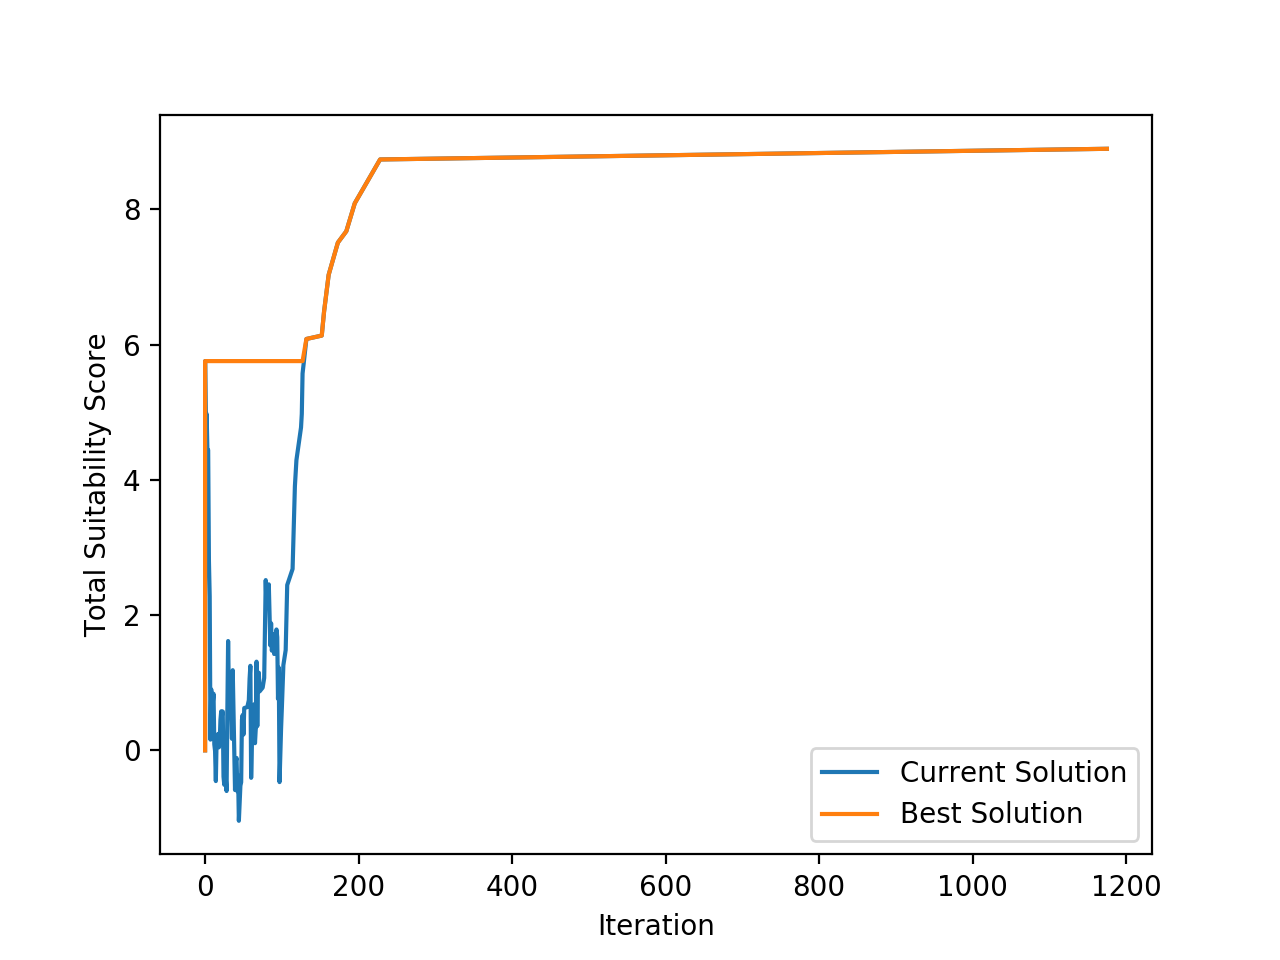

Text(0,0.5,u'Total Suitability Score')

In [49]:
time = np.zeros([1],int)
current_solution = np.zeros([1],float)
best_solution = np.zeros([1],float)
for i in range(200000):
    temperature = 100/(i+1)
    iterate(arr1,arr2,temperature)
    if arr1.previous_favorability != arr1.favorability:
        time = np.append(time,i)
        current_solution = np.append(current_solution,arr1.favorability)
        if arr1.favorability > best_solution[-1]:
            arr_best.adopt_new_arrangement(arr1)
        best_solution = np.append(best_solution,max(arr1.favorability,best_solution[-1]))
    if (i - time[-1]) > 20000:
        break
plt.plot(time,current_solution,label='Current Solution')
plt.plot(time,best_solution,label='Best Solution')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Total Suitability Score')

In [50]:
df = pd.DataFrame(arr_best.guests,columns = ['Name'])
df["Table"] = np.apply_along_axis(lambda y: ["Table " + str(i+1) for i in y], 0, arr_best.tables)
newdf = pd.DataFrame()
for key, values in df.groupby("Table").groups.iteritems():
    newdf[key] = df["Name"].loc[values].values
newdf = newdf.reindex(sorted(newdf.columns), axis=1)
display(newdf)

,Table 1,Table 2,Table 3,Table 4,Table 5
0,David,Charlie,Eliza,Bob,Alice
1,Kelly,Frank,Mary,Greg,Heather
2,Oscar,Igor,Veronica,Larry,Jack
3,Quentin,Ulysses,Walter,Peter,Nancy
4,Tom,Empty Chair,Empty Chair,Rose,Steve
